In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib notebook

from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, cohen_kappa_score, f1_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack
import datetime

import utils
import importlib
importlib.reload(utils)

double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)

/home/max/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv('docs.csv').sample(frac=1).reset_index(drop=True)
df['date'] = df['rated'].apply(lambda x: datetime.datetime.strptime(x[:19],"%Y-%m-%d %H:%M:%S"))
df = df[df['date'] > datetime.datetime(2018,6,1,0,0,0)].reset_index(drop=True)
print(df.shape)
y = df['relevant']
df.head()

(1984, 13)


,Unnamed: 0,UT_id,authors,content,first_author,id,rated,relevant,tag,title,wosarticle__de,wosarticle__wc,date
0,2276,WOS:000080430300002,"Vaje, PI, Singh, BR, Lal, R",Nitrogen and water are both major limiting fac...,"Vaje, PI",362254,2018-09-20 08:39:09.336502+00:00,1,753,Erosional effects on nitrogen balance in maize...,leaching; nitrogen balance; nutrient depletion...,['Soil Science'],2018-09-20 08:39:09
1,1047,WOS:000254798800008,"Kleijn, R, van der Voet, E, de Haes, HAU",over the last decades the concepts of Integrat...,"Kleijn, R",61690,2018-09-18 16:25:35.952983+00:00,1,753,The need for combining IEA and IE tools: The p...,integrated assessment; integrated environmenta...,['Ecology; Economics; Environmental Sciences; ...,2018-09-18 16:25:35
2,410,WOS:000226980600009,"Weeks, JM, Spurgeon, DJ, Svendsen, C, Hankard,...",During the period 1996-1999 a joint field rese...,"Weeks, JM",730086,2018-09-21 09:20:21.268926+00:00,1,760,Critical analysis of soil invertebrate biomark...,biomarkers; soil invertebrates,['Ecology; Environmental Sciences; Toxicology'],2018-09-21 09:20:21
3,1699,WOS:000342693800011,"Zupan, I, Peharda, M, Dolenec, T, Dolenec, M, ...",In support of aquaculture development and sust...,"Zupan, I",650465,2018-09-24 04:34:40.007447+00:00,1,760,AQUACULTURE ASSESSMENT OF NOAH'S ARK (ARCA NOA...,Noah's ark; Arca noae; integrated aquaculture;...,['Fisheries; Marine & Freshwater Biology'],2018-09-24 04:34:40
4,2127,WOS:000183674300008,"Bekalo, SA, Brophy, M, Welford, AG",In the light of fresh international initiative...,"Bekalo, SA",301831,2018-09-19 15:12:10.752492+00:00,0,753,The development of education in post-conflict ...,post-conflict education development; Somalilan...,['Education & Educational Research'],2018-09-19 15:12:10


### The sample is unbalanced, with 22% negatives

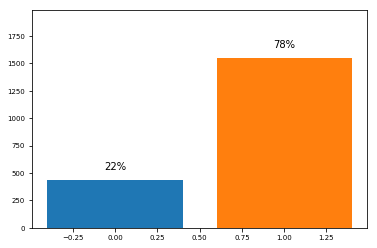

In [3]:
plt.close()
fig, ax = plt.subplots()
i = 0
for name, group in df.groupby('relevant'):
    s = group['id'].size
    plt.bar(i, s)
    plt.text(i, s + df['id'].size*0.05, "{:.0%}".format(s/df['id'].size),ha="center")
    i+=1
    
plt.ylim(0,df['id'].size)
#fig.tight_layout()
    
plt.show()
    

## Generating various feature collections for input

In [4]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=15, max_df=0.6, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)

ab_X = vec.fit_transform(df['content'])
ab_X.shape

(1984, 2088)

In [5]:
vec = TfidfVectorizer(
    ngram_range=(1,3),
    min_df=5, max_df=0.8, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)

ab_X_dense = vec.fit_transform(df['content'])
ab_X_dense.shape

(1984, 6368)

In [6]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=10, max_df=0.9, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)


ti_X = vec.fit_transform(df['title'])
ti_X.shape

(1984, 358)

In [7]:
# keywords
import re
def kw_tokenize(X):
    for x in X.split(';'):
        t = x.replace('[','').replace(']','').strip()
        t = t.replace("'","")
        t = re.sub('^, ','',t)
        t = t.replace(',,',',')
        if len(x) < 2:
            continue
        yield t

vec = CountVectorizer(
    min_df=3, max_df=0.9, strip_accents='unicode', 
    stop_words="english",
    tokenizer=kw_tokenize
)
df['wosarticle__wc'] = df['wosarticle__wc'].fillna("")
wc_X = vec.fit_transform(df['wosarticle__wc'])
print(wc_X.shape)
vec.get_feature_names()[:5]

(1984, 162)


['agricultural economics & policy',
 'agricultural engineering',
 'agriculture, dairy & animal science',
 'agriculture, multidisciplinary',
 'agronomy']

In [8]:
# keywords

vec = CountVectorizer(
    min_df=3, max_df=0.9, strip_accents='unicode', 
    stop_words="english",
    tokenizer=kw_tokenize
    #tokenizer=lambda x: x.split('; ')
)
df['wosarticle__de'] = df['wosarticle__de'].fillna("")
de_X = vec.fit_transform(df['wosarticle__de'])
print(de_X.shape)
vec.get_feature_names()[:5]

(1984, 323)


['activated carbon',
 'adaptation',
 'adsorption',
 'africa',
 'agricultural sustainability']

In [9]:
vec = CountVectorizer(
    ngram_range=(1,1),
    min_df=1, max_df=0.9, strip_accents='unicode', 
    stop_words="english",tokenizer=utils.tokenize
)
df['authors'] = df['authors'].fillna("")
au_X = vec.fit_transform(df['authors'])
print(au_X.shape)
vec.get_feature_names()[:5]

vec = CountVectorizer(
    min_df=3, max_df=0.9, strip_accents='unicode', 
    stop_words="english",
    tokenizer=utils.sus_tokenize
    #tokenizer=lambda x: x.split('; ')
)
sus_X = vec.fit_transform(df['content'])
print(sus_X.shape)
vec.get_feature_names()[:25]

(1984, 5561)
(1984, 405)


['2005_1',
 '2015_1',
 'acceptable_-1',
 'achieve_-1',
 'achieving_-1',
 'activity_-1',
 'activity_1',
 'advance_-1',
 'agricultural_-1',
 'agricultural_1',
 'agriculture._1',
 'agriculture_1',
 'along_-1',
 'also_1',
 'alternative_-1',
 'alternative_1',
 'alternatives_1',
 'application_-1',
 'approach_-1',
 'approach_1',
 'approaches_-1',
 'approaches_1',
 'aquaculture._1',
 'aquaculture_1',
 'areas._-1']

In [ ]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=10, max_df=0.9, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)


ti_X = vec.fit_transform(df['title'])
ti_X.shape

In [10]:
X = X = hstack([ab_X,ti_X,wc_X,de_X],format="csr")
X.shape

(1984, 2931)

In [11]:
nmf = NMF(n_components=125,random_state=1,
          alpha=.1, l1_ratio=.5)

W = nmf.fit_transform(X)

## Testing the different feature collections with various models

In [12]:
#ab, ti, de, au, wc, W

xs = [
    {
        'title':'abstracts',
        'X': ab_X
    },
    {
        'title':'keywords',
        'X': de_X
    },
#]
#extra_xs = [
    {
        'title':'titles, abs,\nkw, wc',
        'X': hstack([ab_X,ti_X,de_X,wc_X],format="csr")
    },
    {
        'title':'titles, abs',
        'X': hstack([ab_X,ti_X],format="csr")
    },
    {
        'title':'topic_model_all',
        'X': W
    },
    {
        'title': 'abs, kw, sus',
        'X': hstack([ab_X,de_X,sus_X],format="csr")
    }
]
import copy
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',C=5,probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]
for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []
    model['f'] = []

kf = KFold(n_splits=10)

for x in xs:
    print(x['title'])
    x['models'] = copy.deepcopy(models)
    local_x = x['X']
    i=0
    for train_index, test_index in kf.split(X):
        #train_index = utils.undersample(train_index,y,0.4)
        for j,model in enumerate(x['models']):
            clf = model['model']
            i+=1
            model['i'].append(i)
            #clf = SVC(kernel='rbf',probability=True)
            clf.fit(local_x[train_index],y[train_index])
            predictions = clf.predict(local_x[test_index])
            x['models'][j]['e'].append(clf.score(local_x[test_index],y[test_index]))
            # Precision
            x['models'][j]['p'].append(precision_score(predictions,y[test_index]))
            # Recall
            x['models'][j]['r'].append(recall_score(predictions,y[test_index]))
            x['models'][j]['f'].append(f1_score(predictions,y[test_index]))
        

abstracts
keywords
titles, abs,
kw, wc
titles, abs
topic_model_all
abs, kw, sus


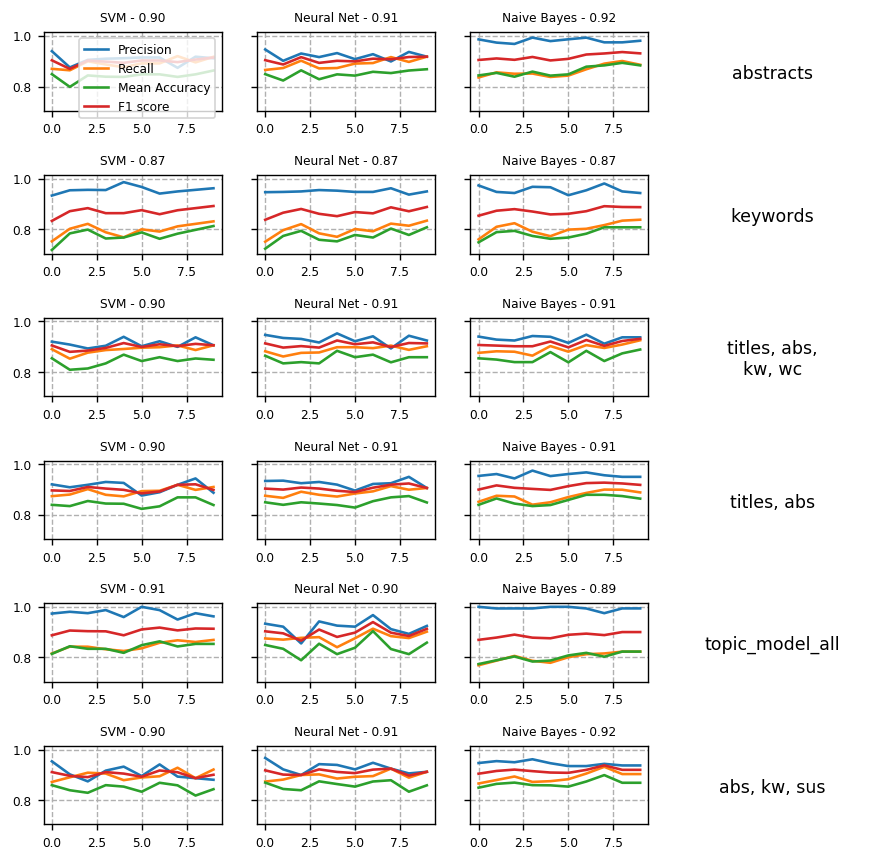

In [13]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(
    len(xs),
    len(xs[0]['models'])+1,
    dpi=125,
    figsize=(double_figure[0],7),
    sharey=True
)
for i, x in enumerate(xs):
    for j, model in enumerate(x['models']):
        ax = axs[i,j]
        ax.plot(model['p'],label="Precision")
        ax.plot(model['r'],label="Recall")
        ax.plot(model['e'],label="Mean Accuracy")
        ax.plot(model['f'],label="F1 score")

        ax.set_title("{} - {:.2f}".format(model['title'],np.mean(model['f'])))
        ax.grid()
    ax = axs[i,3]
    ax.text(0.5,0.85,x['title'],ha="center",va="center")
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    ax.axis('off')
axs[0,0].legend()
fig.tight_layout()
#plt.savefig("plots/model_comparison.png")


In [14]:
#ab, ti, de, au, wc, W

xs = [
    {
        'title':'abstracts',
        'X': ab_X
    },
    {
        'title':'keywords',
        'X': de_X
    },
#]
#extra_xs = [
    {
        'title':'titles, abs,\nkw, wc',
        'X': hstack([ab_X,ti_X,de_X,wc_X],format="csr")
    },
    {
        'title':'titles, abs',
        'X': hstack([ab_X,ti_X],format="csr")
    },
    {
        'title':'topic_model_all',
        'X': W
    },
    {
        'title': 'abs, kw, sus',
        'X': hstack([ab_X,de_X,sus_X],format="csr")
    }
]
import copy
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',C=5,probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]
for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []
    model['f'] = []


for x in xs:
    x['models'] = copy.deepcopy(models)
    local_x = x['X']
    i=0
    print(x['title'])
    for s in range(9):
        train = df.sample(frac=(s+1)*0.1).copy()
        test = df[~df['id'].isin(train['id'])].copy()
        train_index = train.index
        test_index = test.index
        #train_index = utils.undersample(train_index,y,0.4)
        for j,model in enumerate(x['models']):
            clf = model['model']
            i+=1
            model['i'].append(i)
            #clf = SVC(kernel='rbf',probability=True)
            clf.fit(local_x[train_index],y[train_index])
            predictions = clf.predict(local_x[test_index])
            x['models'][j]['e'].append(clf.score(local_x[test_index],y[test_index]))
            # Precision
            x['models'][j]['p'].append(precision_score(predictions,y[test_index]))
            # Recall
            x['models'][j]['r'].append(recall_score(predictions,y[test_index]))
            x['models'][j]['f'].append(f1_score(predictions,y[test_index]))
        

abstracts
keywords
titles, abs,
kw, wc
titles, abs
topic_model_all
abs, kw, sus


In [15]:
## Most models work fairly well even with small training sets

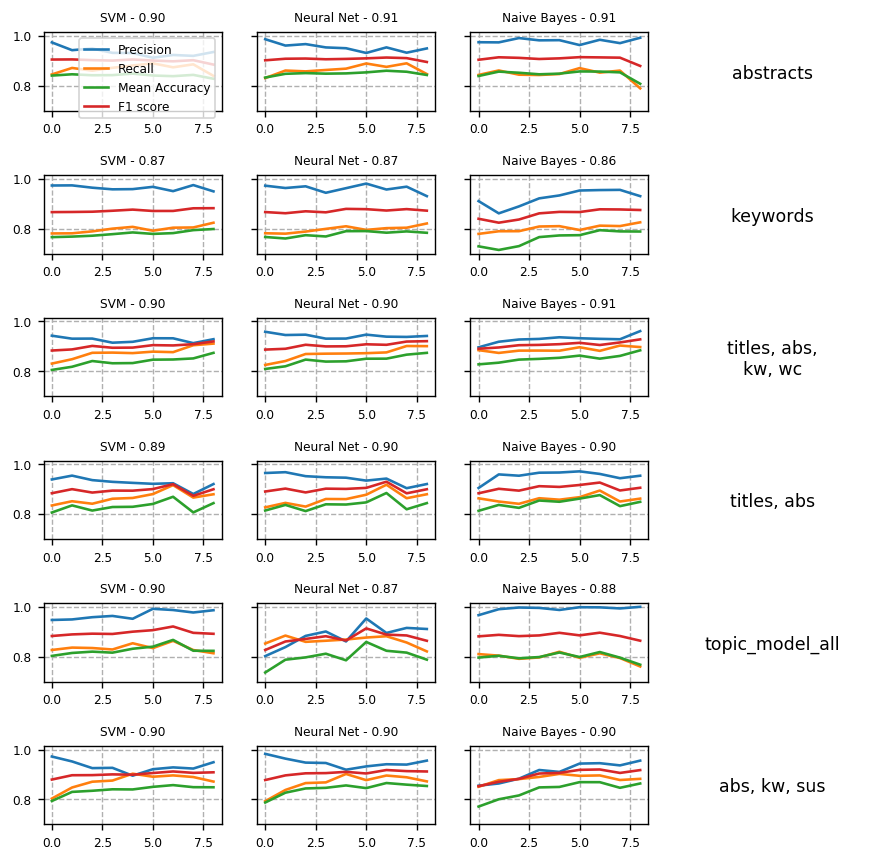

In [16]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(
    len(xs),
    len(xs[0]['models'])+1,
    dpi=125,
    figsize=(double_figure[0],7),
    sharey=True
)
for i, x in enumerate(xs):
    for j, model in enumerate(x['models']):
        ax = axs[i,j]
        ax.plot(model['p'],label="Precision")
        ax.plot(model['r'],label="Recall")
        ax.plot(model['e'],label="Mean Accuracy")
        ax.plot(model['f'],label="F1 score")

        ax.set_title("{} - {:.2f}".format(model['title'],np.mean(model['f'])))
        ax.grid()
    ax = axs[i,3]
    ax.text(0.5,0.85,x['title'],ha="center",va="center")
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    ax.axis('off')
axs[0,0].legend()
fig.tight_layout()
#plt.savefig("plots/model_comparison.png")


## Undersampling

In [17]:
#ab, ti, de, au, wc, W

xs = [
    {
        'title':'abstracts',
        'X': ab_X
    },
    {
        'title':'keywords',
        'X': de_X
    },
#]
#extra_xs = [
    {
        'title':'titles, abs,\nkw, wc',
        'X': hstack([ab_X,ti_X,de_X,wc_X],format="csr")
    },
    {
        'title':'titles, abs',
        'X': hstack([ab_X,ti_X],format="csr")
    },
    {
        'title':'topic_model_all',
        'X': W
    },
    {
        'title': 'abs, kw, sus',
        'X': hstack([ab_X,de_X,sus_X],format="csr")
    }
]
import copy
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',C=5,probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title':"Big Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(100,10,5), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]
for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []
    model['f'] = []


for x in xs:
    x['models'] = copy.deepcopy(models)
    local_x = x['X']
    i=0
    print(x['title'])
    for s in range(9):
        train = df.sample(frac=(s+1)*0.1).copy()
        test = df[~df['id'].isin(train['id'])].copy()
        train_index = utils.undersample(train.index,y,0.6)
        test_index = test.index
        #train_index = utils.undersample(train_index,y,0.4)
        for j,model in enumerate(x['models']):
            clf = model['model']
            i+=1
            model['i'].append(i)
            #clf = SVC(kernel='rbf',probability=True)
            clf.fit(local_x[train_index],y[train_index])
            predictions = clf.predict(local_x[test_index])
            x['models'][j]['e'].append(clf.score(local_x[test_index],y[test_index]))
            # Precision
            x['models'][j]['p'].append(precision_score(predictions,y[test_index]))
            # Recall
            x['models'][j]['r'].append(recall_score(predictions,y[test_index]))
            x['models'][j]['f'].append(f1_score(predictions,y[test_index]))
        

abstracts
fraction of 1s: 0.77
fraction of 1s: 0.77
fraction of 1s: 0.78
fraction of 1s: 0.77
fraction of 1s: 0.76
fraction of 1s: 0.79
fraction of 1s: 0.78
fraction of 1s: 0.78
fraction of 1s: 0.78
keywords
fraction of 1s: 0.75
fraction of 1s: 0.78
fraction of 1s: 0.80
fraction of 1s: 0.78
fraction of 1s: 0.78
fraction of 1s: 0.77
fraction of 1s: 0.79
fraction of 1s: 0.78
fraction of 1s: 0.78
titles, abs,
kw, wc
fraction of 1s: 0.82
fraction of 1s: 0.76
fraction of 1s: 0.80
fraction of 1s: 0.79
fraction of 1s: 0.79
fraction of 1s: 0.79
fraction of 1s: 0.78
fraction of 1s: 0.78
fraction of 1s: 0.78
titles, abs
fraction of 1s: 0.77
fraction of 1s: 0.78
fraction of 1s: 0.79
fraction of 1s: 0.78
fraction of 1s: 0.79
fraction of 1s: 0.77
fraction of 1s: 0.78
fraction of 1s: 0.79
fraction of 1s: 0.78
topic_model_all
fraction of 1s: 0.81
fraction of 1s: 0.76
fraction of 1s: 0.78
fraction of 1s: 0.78
fraction of 1s: 0.78
fraction of 1s: 0.79
fraction of 1s: 0.78
fraction of 1s: 0.78
fraction 

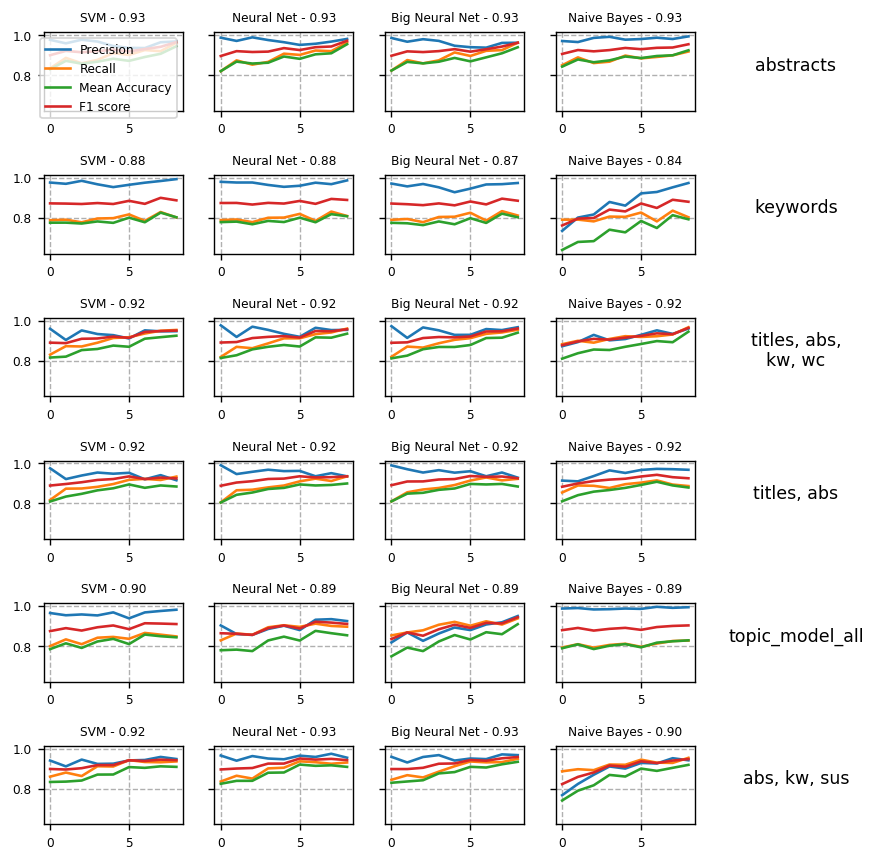

In [18]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(
    len(xs),
    len(xs[0]['models'])+1,
    dpi=125,
    figsize=(double_figure[0],7),
    sharey=True
)
for i, x in enumerate(xs):
    for j, model in enumerate(x['models']):
        ax = axs[i,j]
        ax.plot(model['p'],label="Precision")
        ax.plot(model['r'],label="Recall")
        ax.plot(model['e'],label="Mean Accuracy")
        ax.plot(model['f'],label="F1 score")

        ax.set_title("{} - {:.2f}".format(model['title'],np.mean(model['f'])))
        ax.grid()
    ax = axs[i,len(xs[0]['models'])]
    ax.text(0.5,0.85,x['title'],ha="center",va="center")
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    ax.axis('off')
axs[0,0].legend()
fig.tight_layout()
#plt.savefig("plots/model_comparison.png")


## By adjusting our probability threshold we can prioritise precision or recall

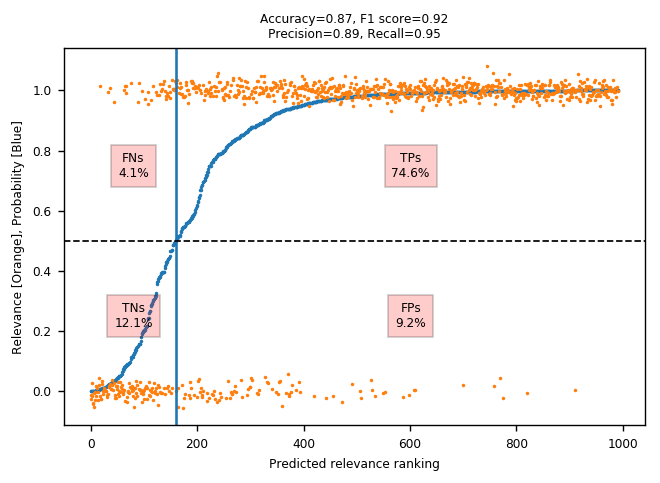

In [79]:
importlib.reload(utils)

local_x = ab_X

train = df.sample(frac=0.5).copy()
test = df[~df['id'].isin(train['id'])].copy()

clf = MLPClassifier(
            solver='lbfgs', 
            alpha=0.5,
            hidden_layer_sizes=(1200), 
            random_state=1
        )
#clf = MultinomialNB(alpha=0.1) 

clf.fit(local_x[train.index],y[train.index])

fig, ax = plt.subplots(dpi=125)

#print("Accuracy: {:.2f}".format(clf.score(local_x[test.index],y[test.index])))

utils.plot_model_accuracy(clf,local_x[test.index],y[test.index],ax, 0.5)

In [78]:
local_x.shape

(1984, 2088)

Average precision-recall score: 0.97


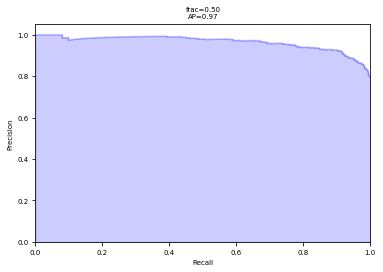

In [20]:
importlib.reload(utils)

fig, ax = plt.subplots()
utils.precision_recall_plot(clf,local_x[test.index],y[test.index],ax,0.5)

Confusion matrix, without normalization
[[ 99 110]
 [ 11 772]]


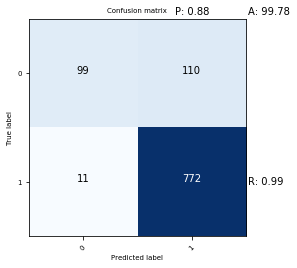

In [38]:
from sklearn.metrics import confusion_matrix
fig = plt.figure()
cnf = confusion_matrix(y[test.index],clf.predict(ab_X[test.index]))
utils.plot_confusion_matrix(cnf,classes=[0,1])

Confusion matrix, without normalization
[[  0 209]
 [  0 783]]
Confusion matrix, without normalization
[[ 37 172]
 [  1 782]]
Confusion matrix, without normalization
[[ 56 153]
 [  6 777]]
Confusion matrix, without normalization
[[ 71 138]
 [  6 777]]
Confusion matrix, without normalization
[[ 83 126]
 [  8 775]]
Confusion matrix, without normalization
[[ 99 110]
 [ 11 772]]
Confusion matrix, without normalization
[[113  96]
 [ 22 761]]
Confusion matrix, without normalization
[[132  77]
 [ 54 729]]
Confusion matrix, without normalization
[[169  40]
 [109 674]]


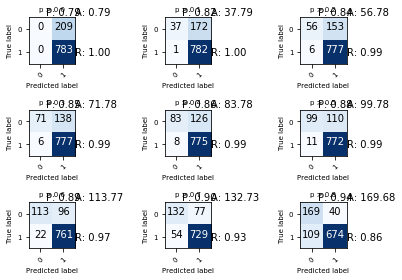

In [36]:
y_prob = clf.predict_proba(local_x[test.index])[:,1]
t = 0.1
y_pred = np.where(y_prob>t,1,0)
fig = plt.figure()
for i in range(9):
    t = i*0.1
    y_pred = np.where(y_prob>t,1,0)
    ax = fig.add_subplot(3,3,i+1)
    cnf = confusion_matrix(y[test.index],y_pred)
    utils.plot_confusion_matrix(cnf,classes=[0,1])
    ax.set_title("p > {:.1f}".format(t))

#plt.colorbar()
    
fig.tight_layout()

## False positives and false negatives

In [ ]:
test['predicted'] = clf.predict(ab_X[test.index])
test['prob'] = clf.predict_proba(ab_X[test.index])[:,1]
fps = test[test['predicted']-test['relevant']==1].sort_values('prob',ascending=False)

fps.head()

In [ ]:
print('#########\nFALSE POSITIVES')

for i, row in fps.head(5).iterrows():
    print('\n####')
    print(row['title'])
    print("predicted: {:.2}, rated: {}".format(row['prob'],row['relevant']))
    print(row['content'])

In [ ]:
fns = test[test['predicted']-test['relevant']==-1].sort_values('prob')

fns.head()

In [ ]:
print('#########\nFALSE NEGATIVES')

for i, row in fns.head(5).iterrows():
    print('\n####')
    print(row['title'])
    print("predicted: {:.2}, rated: {}".format(row['prob'],row['relevant']))
    print(row['content'])

## Todos:
- Sustainable x features
- Ensemble methods, autosklearn
- Error overlap
- category exclusion

In [ ]:



sus_tokenize( "The concept of long-term sustainable development")

# keywords



In [ ]:
importlib.reload(utils)

local_x = sus_X
local_x = hstack([ab_X,sus_X],format="csr")


train = df.sample(frac=0.5).copy()
test = df[~df['id'].isin(train['id'])].copy()

train_index = utils.undersample(train.index,y,0.6)

clf = MLPClassifier(
            solver='lbfgs', 
            alpha=0.2,
            hidden_layer_sizes=(100,20,5), 
            random_state=1
        )
#clf = MultinomialNB(alpha=0.1) 

clf.fit(local_x[train_index],y[train_index])


print("Accuracy: {:.2f}".format(clf.score(local_x[test.index],y[test.index])))



In [ ]:
fig, ax = plt.subplots(dpi=125)

utils.plot_model_accuracy(clf,local_x[test.index],y[test.index],ax, 0.95)

In [ ]:
model = clf
y_test = y[test.index]
x_test = local_x[test.index]
y_prob = model.predict_proba(x_test)
prob_y_true = y_prob[:,1]
prob_y_false = y_prob[:,0]

order = np.argsort(prob_y_true)
ordered_prob = prob_y_true[order]

order

np.array(y_test)[order]

In [ ]:
fig, ax = plt.subplots(dpi=125)
utils.precision_recall_plot(clf,local_x[test.index],y[test.index],ax,0.5)

In [ ]:
cnf = confusion_matrix(y[test.index],clf.predict(local_x[test.index]))
utils.plot_confusion_matrix(cnf,classes=[0,1])